In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage

#Load Dataset

In [19]:
data = pd.read_csv('/content/Wholesale customers data.csv')
data

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


#Preprocessing

In [20]:
# Drop any missing values (if present)
data.dropna(inplace=True)

# Features for clustering
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Store evaluation results
results = []

data

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


#Section 1: K-Means Clustering

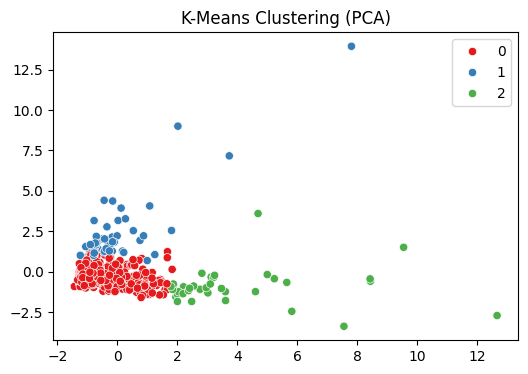

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_nmi = normalized_mutual_info_score(data['Channel'], kmeans_labels)
results.append(['K-Means', kmeans_silhouette, kmeans_db, kmeans_nmi, len(np.unique(kmeans_labels))])
plt.figure(figsize=(6,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set1')
plt.title("K-Means Clustering (PCA)")
plt.show()

#Section 2: Agglomerative Clustering

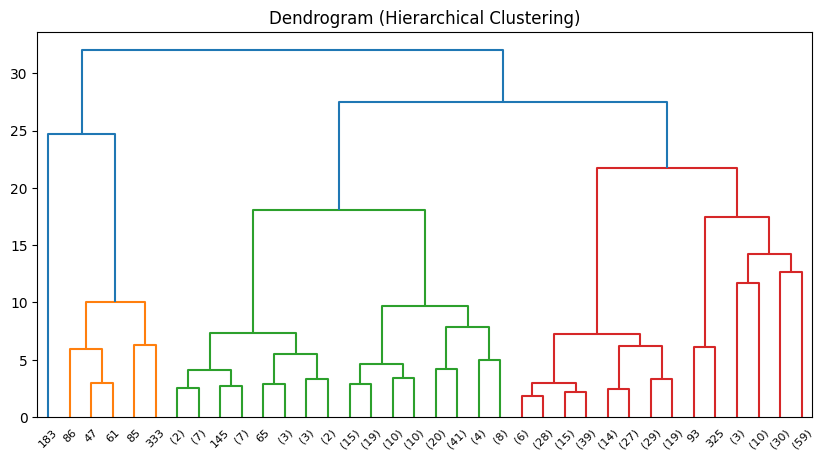

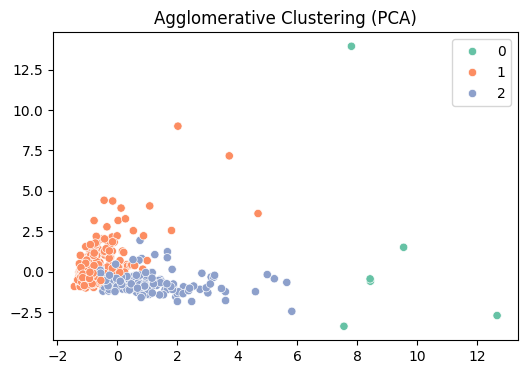

In [22]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_db = davies_bouldin_score(X_scaled, agg_labels)
agg_nmi = normalized_mutual_info_score(data['Channel'], agg_labels)
results.append(['Hierarchical', agg_silhouette, agg_db, agg_nmi, len(np.unique(agg_labels))])
linked = linkage(X_scaled, 'ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Dendrogram (Hierarchical Clustering)")
plt.show()
plt.figure(figsize=(6,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agg_labels, palette='Set2')
plt.title("Agglomerative Clustering (PCA)")
plt.show()

#Section 3: DBSCAN Clustering

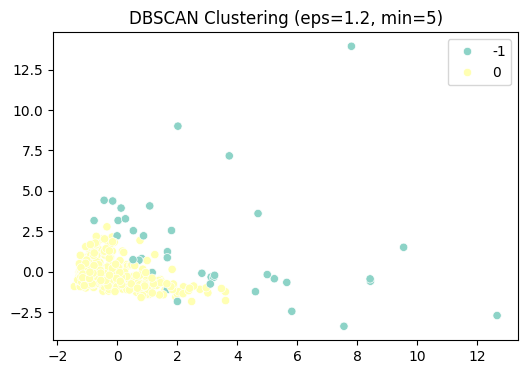

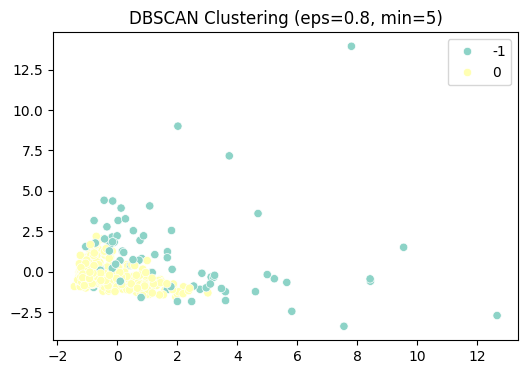

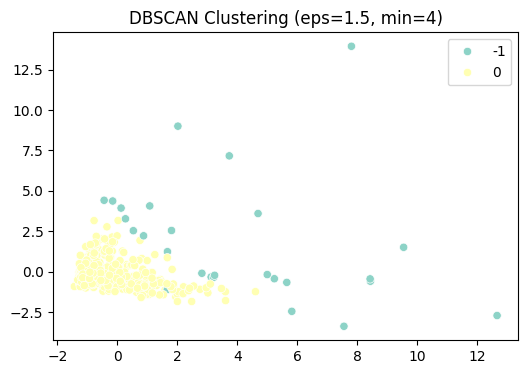

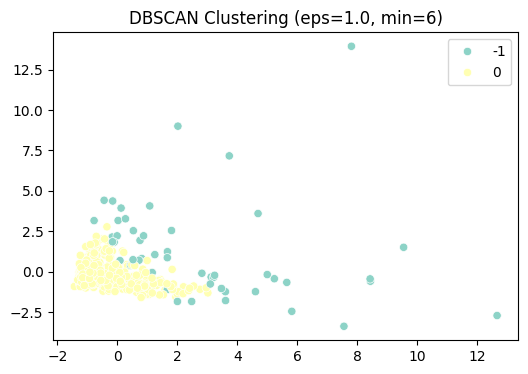

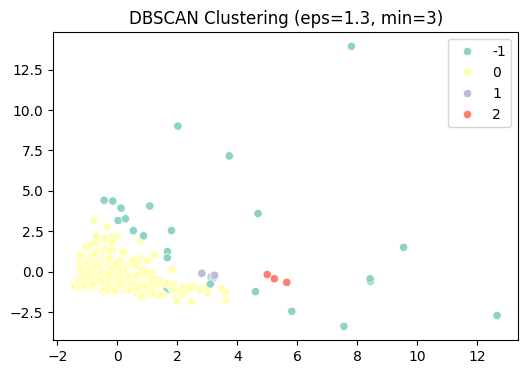

In [23]:
dbscan_params = [(1.2, 5), (0.8, 5), (1.5, 4), (1.0, 6), (1.3, 3)]
for eps, min_samples in dbscan_params:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db_labels = db.fit_predict(X_scaled)
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
    n_noise = list(db_labels).count(-1)

    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, db_labels)
        dbi = davies_bouldin_score(X_scaled, db_labels)
        nmi = normalized_mutual_info_score(data['Channel'], db_labels)
    else:
        silhouette = np.nan
        dbi = np.nan
        nmi = np.nan

    results.append([f'DBSCAN (eps={eps}, min={min_samples})', silhouette, dbi, nmi, n_clusters])

    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_labels, palette='Set3', legend='full')
    plt.title(f"DBSCAN Clustering (eps={eps}, min={min_samples})")
    plt.show()


#Section 4: Tabulate Evaluation

In [24]:
results_df = pd.DataFrame(results, columns=['Algorithm', 'Silhouette Score', 'Davies-Bouldin Index', 'NMI', 'No. of Clusters'])
results_df

,Algorithm,Silhouette Score,Davies-Bouldin Index,NMI,No. of Clusters
0,K-Means,0.458263,1.249095,0.176707,3
1,Hierarchical,0.264609,1.284521,0.352871,3
2,"DBSCAN (eps=1.2, min=5)",NaN,NaN,NaN,1
3,"DBSCAN (eps=0.8, min=5)",NaN,NaN,NaN,1
4,"DBSCAN (eps=1.5, min=4)",NaN,NaN,NaN,1
5,"DBSCAN (eps=1.0, min=6)",NaN,NaN,NaN,1
6,"DBSCAN (eps=1.3, min=3)",0.424572,1.925215,0.038262,3


#Comparing Algorithms

In this experiment, we applied three clustering algorithms—K-Means, Agglomerative Hierarchical Clustering, and DBSCAN—on the Wholesale Customers dataset. K-Means produced the most compact and well-separated clusters, achieving the highest Silhouette Score (0.458) and the lowest Davies-Bouldin Index (1.249), indicating strong intra-cluster similarity and good separation between clusters. Although its Normalized Mutual Information (NMI = 0.177) was relatively low, it still outperformed DBSCAN in consistency.

Agglomerative Hierarchical Clustering also generated three clusters but showed a lower Silhouette Score (0.265) and a slightly higher Davies-Bouldin Index (1.285), suggesting less effective cluster compactness. However, it achieved the highest NMI (0.353) among all methods, indicating better alignment with the ground truth labels (Channel).

DBSCAN, across most parameter settings, detected only one cluster, failing to provide meaningful separation. Only one configuration (eps=1.3, min=3) successfully identified 3 clusters but resulted in a lower Silhouette Score (0.425), a high Davies-Bouldin Index (1.925), and very low NMI (0.038), indicating weak structure and poor alignment. While DBSCAN is valuable for identifying noise and non-spherical clusters, it was highly sensitive to parameter tuning and did not perform well on this dataset.

Overall, K-Means provided the best clustering performance for this dataset, while DBSCAN demonstrated limitations due to its sensitivity and the nature of the data.